In [1]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import random
random.seed(2911)
import numpy as np
np.random.seed(2911)
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import cm
import anndata as ad
import celltypist as ct
import scFates as sf
seed=2911
import palantir

/data/mcri_brain/mcri_marian/env/conda/rapidai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
cffi mode is CFFI_MODE.ANY
R home found: /data/mcri_brain/mcri_marian/env/conda/rapidai/lib/R
R library path: /usr/local/lib:/usr/local/lib64:/usr/local/lib:/usr/local/lib64::/.singularity.d/libs
LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib64:/usr/local/lib:/usr/local/lib64::/.singularity.d/libs
Default options to initialize R: rpy2, --quiet, --no-save
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
5: Setting LC_PAPER failed, using "C" 
6: Setting LC_MEASUREMENT failed, using "C" 
R is already initialized. No need to initialize.


In [2]:
from anndata.io import read_csv, read_excel
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings(
    "ignore",
    message="Importing read_csv from `anndata` is deprecated.*",
    category=FutureWarning
)
warnings.filterwarnings(
    "ignore",
    message="Importing read_excel from `anndata` is deprecated.*",
    category=FutureWarning
)
import os
os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
import os

os.environ["LC_ALL"] = "C"
os.environ["LANG"] = "C"

In [3]:
adata=ad.read('/data/mcri_brain/data/2024_hackathon_anndata.h5ad')
adata

AnnData object with n_obs × n_vars = 19663 × 62754
    obs: 'nCount_RNA', 'nFeature_RNA', 'Barcode', 'CellLine', 'Day'
    var: 'Ensemble', 'Gene_ID'

In [4]:
adata.var.index=adata.var['Gene_ID'].astype(str)
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [5]:
adata.obs[['Day','CellLine']].value_counts().unstack(-1).min().min()

138

In [6]:
adata.obs['Day_x_line']=adata.obs['Day'].astype(str)+'_'+adata.obs['CellLine'].astype(str)

In [7]:
adata=adata[adata.obs['CellLine']=='FSA0024I1']

... storing 'Day_x_line' as categorical


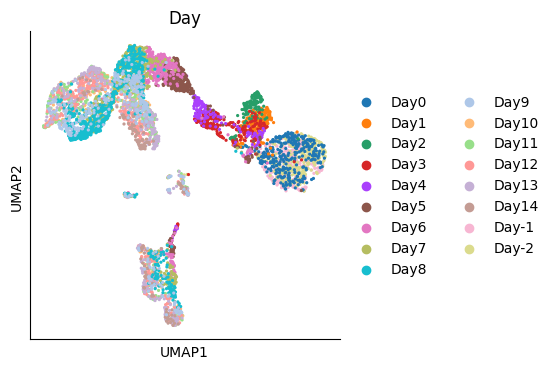

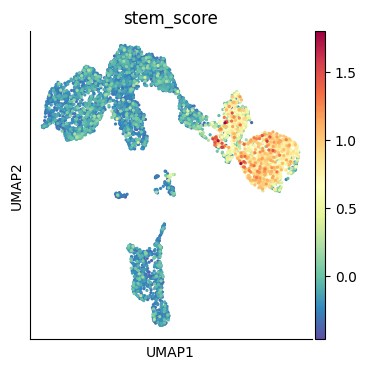

In [8]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
adata.raw=adata
sc.pp.highly_variable_genes(adata,n_top_genes=2000,subset=True)
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['Day'])
sc.tl.score_genes(adata,['NANOG','SOX2','POU5F1','ERBB2'],score_name='stem_score')
sc.pl.umap(adata,color=['stem_score'])
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res)#,n_eigs=4)# reduced for simplicity)
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values

inferring a principal tree --> parameters used 
    100 principal points, sigma = 0.025, lambda = 150, metric = euclidean
    fitting:   0%|          | 0/200 [00:00<?, ?it/s]

init


    fitting:   0%|          | 1/200 [00:01<03:19,  1.00s/it]

/data/mcri_brain/mcri_marian/env/conda/rapidai/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


    fitting:  48%|████▊     | 96/200 [00:03<00:03, 31.35it/s]
    converged
    finished (0:00:03) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.
automatic root selection using stem_score values
node 32 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


... storing 'seg' as categorical


    finished (0:00:36) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


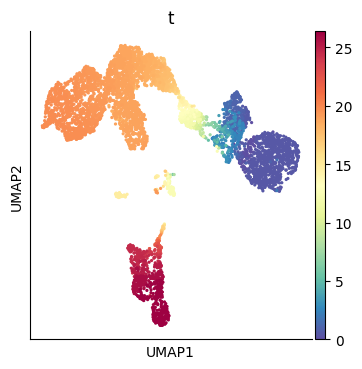

In [9]:
sf.tl.tree(adata,method="ppt",Nodes=100,use_rep="palantir",
            device="gpu",seed=1,ppt_lambda=150,ppt_sigma=0.025,ppt_nsteps=200)
sf.tl.root(adata,"stem_score")
sf.tl.pseudotime(adata,n_jobs=40,n_map=100,seed=42)
sc.pl.umap(adata,color="t")

In [10]:
adata.obs['time']=adata.obs['t']

adata.var.index.name=None
adata.raw.var.index.name=None
adata.write('Hackathon_line1.h5ad')

In [3]:
adata=ad.read('./line1/Hackathon_line1.h5ad')
adata.raw

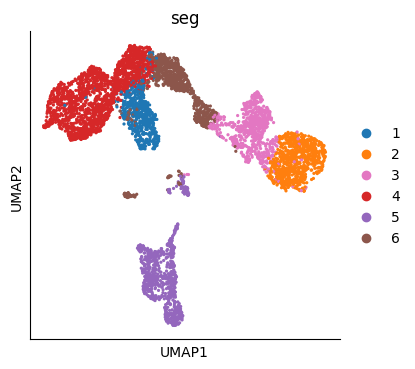

In [5]:
sc.pl.umap(adata,color="seg")

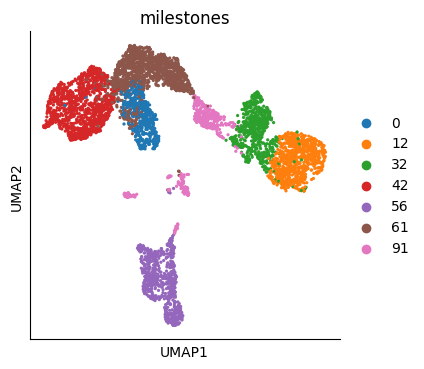

In [7]:
sc.pl.umap(adata,color="milestones")

Generating dendrogram of tree
    segment : 100%|██████████| 6/6 [01:41<00:00, 16.97s/it]
    finished (0:01:41) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


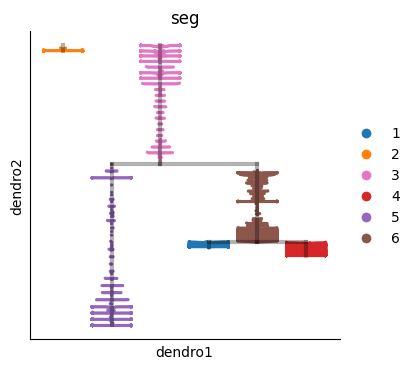

In [8]:
sf.tl.dendrogram(adata, n_jobs=20)
sf.pl.dendrogram(adata,color="seg")

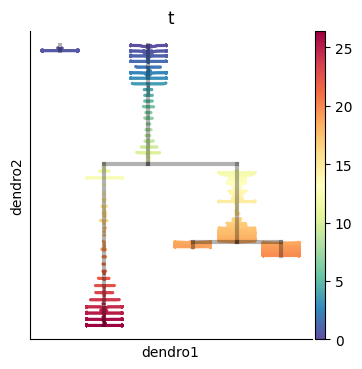

In [9]:
sf.pl.dendrogram(adata,color="t")

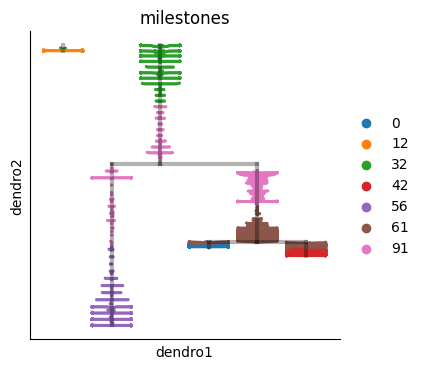

In [10]:
sf.pl.dendrogram(adata,color="milestones")

test features for association with the trajectory
    single mapping : 100%|██████████| 2000/2000 [00:46<00:00, 42.93it/s]
    found 587 significant features (0:00:46) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.
reapplied filters, 1012 significant features


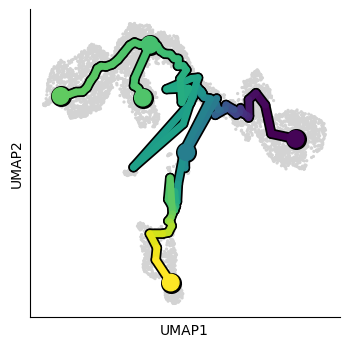

In [15]:
sf.tl.test_association(adata,n_jobs=20)
sf.tl.test_association(adata,reapply_filters=True,A_cut=.5)
sf.pl.trajectory(adata,basis="umap")

In [16]:
sf.tl.fit(adata,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 1012/1012 [00:38<00:00, 26.56it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:39) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


testing fork
    single mapping
    Differential expression: 100%|██████████| 1012/1012 [00:36<00:00, 27.59it/s]
    test for upregulation for each leave vs root
    upreg 42: 100%|██████████| 456/456 [00:00<00:00, 801.55it/s]
    finished (0:00:38) --> added 
    .uns['32->56<>42']['fork'], DataFrame with fork test results.
    branch specific features: 56: 57, 42: 16
    finished --> updated 
    .uns['32->56<>42']['fork'], DataFrame updated with additionnal 'branch' column.


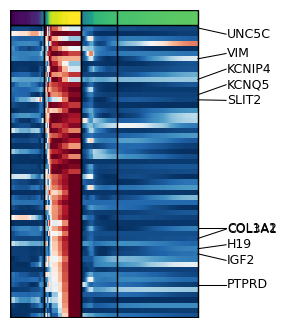

In [17]:
sf.tl.test_fork(adata,root_milestone="32",milestones=["56","42"],n_jobs=40,rescale=True)
sf.tl.branch_specific(adata,root_milestone="32",milestones=["56","42"],effect=1)
g1=sf.pl.trends(adata, root_milestone="32",milestones=["56","42"],branch="56", plot_emb=False,ordering="max",return_genes=True)

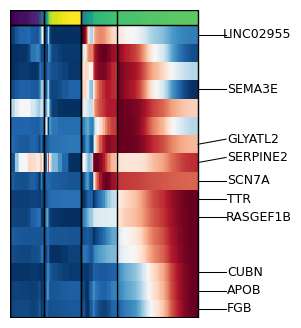

In [18]:
g2=sf.pl.trends(adata, root_milestone="32",milestones=["56","42"],branch="42", plot_emb=False,ordering="max",return_genes=True)

In [ ]:
sf.pl.single_trend(adata,"SOX6",basis="dendro",wspace=.1)

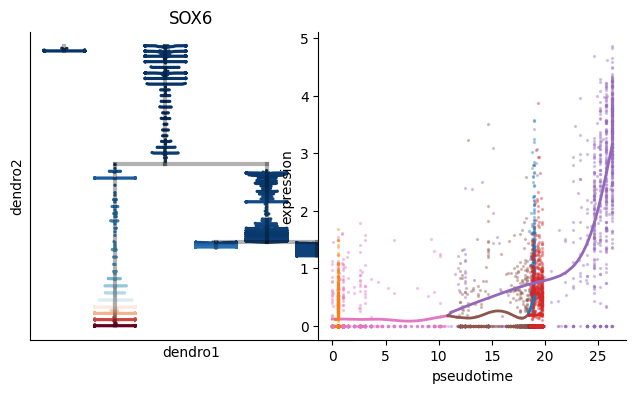

In [20]:
sf.pl.single_trend(adata,"SOX6",basis="dendro",wspace=-.25)

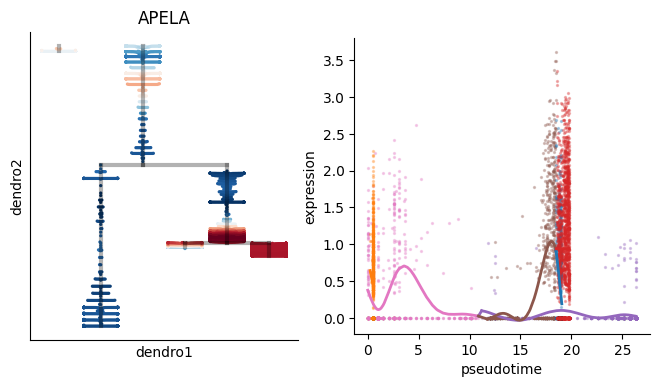

In [21]:
sf.pl.single_trend(adata,"APELA",basis="dendro",wspace=.1)

In [22]:
adata.write('./line1/Hackathon_line1_analised.h5ad')

In [23]:
annotation=pd.read_csv('annotatedCells.tsv',sep='\t',index_col=0)

In [24]:
adata.obs['annotation']=annotation['annotatedCells']

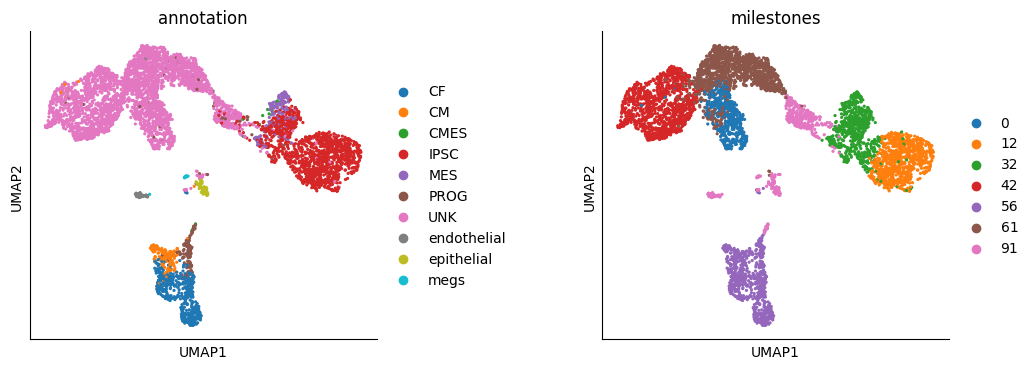

In [27]:
sc.pl.umap(adata,color=['annotation','milestones'],wspace=0.5)